In [11]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import cv2
import numpy as np
import string
import matplotlib.pyplot as plt
import tensorflow as tf

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'captcha-version-2-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F38019%2F306654%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240526%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240526T193055Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0fc59129feaeda58cc2c393297a2b4632ebf8ae38950749e51319ee938ca1dd5d73df5415914b79c4d147c8acb6a7d505287aa7a1d8f3575237830f66a4f2955950e5e0e7ad824492d3c5b9c2b9652cf8d9c141f7e758020f1a75ce86ba71f3c3dc69f9fc450f8677a8817ccb3d96caa2280f0abf26e9e9f5325adb715318904523d1530be9d3c23d198af03a29096a16f579e054615c5624a653871b50ac8116b4ca23f6b2a37c1a917c733837b87fc86dc661a6cc61130c9826eb6f12fe7fd435e054b8e19c27ebc8c23b090e8c4813a506fc0ae9aa1af559fda74d2ab7ad2c8b5fcc341f2b5e101a005dc78c1a2362877af93031091011a5c355a846227c7,captcha-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1193002%2F1994695%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240526%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240526T193055Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6a3e2451b61bafec3b0fb37e0e9e2bc2a14139914abd4d890f4fb4d5660745081834bffc31f3ad5e95cf341af5457bd16029cf2729975c520e791257e4c42b752963ed6e37a8b8a0aa2da0076f08f4e995632c3cfabcec0d3aef6add9de1ef662084927556c08a88321d596fc0dd819f8f7918115b4c7c9da5d277fa9837b2b236142937c0230fcec8cc9967ac70628fc258ae8a7e1cd1e8efe923f928771526ed165b41b3a6ae6a06a5ef324e9d45fbe76217d9311b05f8c94429a42c3b4da77738ef23c1f43e7be3a45ceb7389b148114d7c346f8377406f50b264a1bc4b2025182c52dea657026a9fd6709bc05b04ab1f8e28168c9db580254e8e178c715a'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'
KAGGLE_SYMLINK = 'kaggle'

# Clean up and create necessary directories
!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

# Download and extract datasets
for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 18280840 bytes downloaded
Downloaded and uncompressed: captcha-version-2-images
[==================================================] 373215334 bytes downloaded
Downloaded and uncompressed: captcha-dataset
Data source import complete.


In [12]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Display the directory structure
print(os.listdir("../input"))

['captcha-dataset', 'captcha-version-2-images']


In [13]:
# Initialize main values
img_shape = (50, 200, 1)
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
print(f"Number of symbols: {num_symbols}")


Number of symbols: 36


Sample image shape: (40, 150)


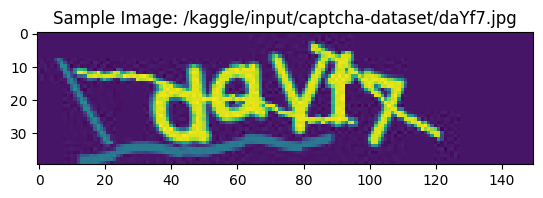

In [14]:
# Load a sample image and display its shape
def load_sample_image(data_path):
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                img_path = os.path.join(root, file)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                return image, img_path

sample_image, sample_image_path = load_sample_image(KAGGLE_INPUT_PATH)
if sample_image is not None:
    print(f"Sample image shape: {sample_image.shape}")
    plt.imshow(sample_image)
    plt.title(f"Sample Image: {sample_image_path}")
    plt.show()
else:
    print("No image found.")

Reshaped sample image shape: (1, 40, 150, 1)


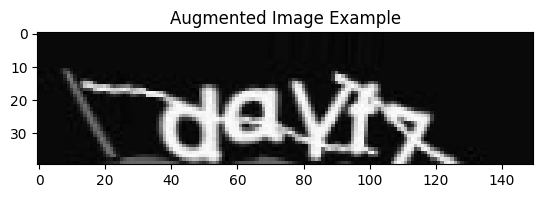

Image shape for model input: (50, 200, 1)


In [15]:
# Reshape the image to have the required rank 4
sample_image = np.expand_dims(sample_image, axis=-1)  # Add channel dimension
sample_image = np.expand_dims(sample_image, axis=0)   # Add batch dimension
print(f"Reshaped sample image shape: {sample_image.shape}")

# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Example of applying data augmentation
augmented_images = next(datagen.flow(sample_image, batch_size=1))
plt.imshow(augmented_images[0].astype('uint8').squeeze(), cmap='gray')
plt.title("Augmented Image Example")
plt.show()

# Initialize main values
img_shape = (50, 200, 1)  # Adjust this if needed based on your dataset

print(f"Image shape for model input: {img_shape}")

In [33]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7

    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(256, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='softmax')(drop)

        outs.append(res)

    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    return model

In [34]:
def preprocess_data():
    n_samples = len(os.listdir('../input/captcha-version-2-images/samples/samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('../input/captcha-version-2-images/samples/samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('../input/captcha-version-2-images/samples/samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs

    # Return final data
    return X, y

In [35]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, recall, precision, f1


In [36]:
model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 50, 200, 32)          320       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 25, 100, 32)          0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 25, 100, 64)          18496     ['max_pooling2d_3[0][0]'

In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [38]:
# Train the model
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]],
                 batch_size=32, epochs=100, verbose=1,
                 validation_split=0.2, callbacks=[es])

Epoch 1/100
25/25 [==============================] - 5s 50ms/step - loss: 19.6688 - dense_11_loss: 3.7845 - dense_13_loss: 3.8532 - dense_15_loss: 3.9305 - dense_17_loss: 4.0606 - dense_19_loss: 4.0401 - dense_11_accuracy: 0.0735 - dense_13_accuracy: 0.0786 - dense_15_accuracy: 0.0696 - dense_17_accuracy: 0.0554 - dense_19_accuracy: 0.0580 - val_loss: 17.4568 - val_dense_11_loss: 3.5027 - val_dense_13_loss: 3.4981 - val_dense_15_loss: 3.5020 - val_dense_17_loss: 3.4729 - val_dense_19_loss: 3.4811 - val_dense_11_accuracy: 0.0876 - val_dense_13_accuracy: 0.0361 - val_dense_15_accuracy: 0.0464 - val_dense_17_accuracy: 0.0979 - val_dense_19_accuracy: 0.1186
Epoch 2/100
25/25 [==============================] - 1s 26ms/step - loss: 14.8995 - dense_11_loss: 2.9337 - dense_13_loss: 2.9311 - dense_15_loss: 2.9746 - dense_17_loss: 2.9834 - dense_19_loss: 3.0766 - dense_11_accuracy: 0.1211 - dense_13_accuracy: 0.1147 - dense_15_accuracy: 0.1173 - dense_17_accuracy: 0.1082 - dense_19_accuracy: 0.1

In [39]:
# Evaluate the model on the test set
score = model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], verbose=1)
print('Test loss and accuracy:', score)

4/4 [==============================] - 0s 10ms/step - loss: 1.7873 - dense_11_loss: 0.0800 - dense_13_loss: 0.3400 - dense_15_loss: 0.4677 - dense_17_loss: 0.4140 - dense_19_loss: 0.4855 - dense_11_accuracy: 0.9700 - dense_13_accuracy: 0.9400 - dense_15_accuracy: 0.8800 - dense_17_accuracy: 0.9200 - dense_19_accuracy: 0.9500
Test loss and accuracy: [1.7872800827026367, 0.080042764544487, 0.34002530574798584, 0.4677426517009735, 0.4139767587184906, 0.48549261689186096, 0.9700000286102295, 0.9399999976158142, 0.8799999952316284, 0.9200000166893005, 0.949999988079071]


In [40]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, recall, precision, f1
# Evaluate the model on the test set
score = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], verbose=1)
print('Test loss:', score[0])

# Get predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y[:, 970:], axis=-1)

# Flatten the predictions and true values for metric calculations
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Calculate metrics
accuracy, recall, precision, f1 = calculate_metrics(y_true_flat, y_pred_flat)

# Print the metrics in a single line
print(f"Test loss: {score[0]:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")


4/4 [==============================] - 0s 14ms/step - loss: 1.7873 - dense_11_loss: 0.0800 - dense_13_loss: 0.3400 - dense_15_loss: 0.4677 - dense_17_loss: 0.4140 - dense_19_loss: 0.4855 - dense_11_accuracy: 0.9700 - dense_13_accuracy: 0.9400 - dense_15_accuracy: 0.8800 - dense_17_accuracy: 0.9200 - dense_19_accuracy: 0.9500
Test loss: 1.7872800827026367
4/4 [==============================] - 0s 6ms/step
Test loss: 1.7873, Accuracy: 0.9320, Recall: 0.9338, Precision: 0.9324, F1 Score: 0.9324


In [46]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Image not detected")
        return None
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, num_symbols))
    captcha = ""
    for i in range(5):
        captcha += symbols[np.argmax(ans[i])]
    return captcha

In [49]:
import matplotlib.pyplot as plt

def plot_predicted_sample(filepath):
    # Predict captcha
    captcha = predict(filepath)

    # Load image
    img = cv2.imread(filepath)

    # Plot image and predicted captcha
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(f"Predicted Captcha: {captcha}")
    plt.show()

1/1 [==============================] - 0s 32ms/step


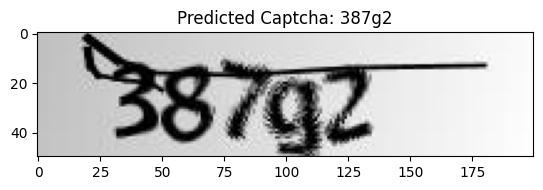

In [50]:
plot_predicted_sample("/kaggle/input/captcha-version-2-images/samples/387g2.png")